# Imports

In [1]:
#Import cluster algorithms
from sklearn.cluster import KMeans, DBSCAN

#Import classifiers
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection as mod_selec
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Import 
import tensorflow as tf


#Import libraries to deal with data
import numpy as np
import pandas as pd
import pickle


#Process data libraries
from skimage import io
from scipy import signal
import pylab, wave
from scipy.io import wavfile

#Miscelanous
import math
import time
import os
import warnings


#Graphs and show images
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches



np.random.seed(10)
np.set_printoptions(suppress=True)
warnings.filterwarnings('ignore')
%matplotlib inline 


2023-05-04 15:20:28.855283: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-04 15:20:28.858643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-04 15:20:28.858668: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Set up el dataset y las funciones

Dataset

In [2]:
dataset_path = os.path.abspath('kaggle_audios')

Funciones de spectograma

In [ ]:
##############################################
#                                            #
#                Spectrogram                 #
#                                            #
##############################################
#Function to retrieve data from wav files
def wavInfo(rec_file):
    sample_rate, samples = wavfile.read(rec_file)
    channels  = wave.open(rec_file, 'r').getnchannels()
    # edit the samples to be from 0 to 7 seconds    
    samples = samples[0:sample_rate*7]
    # filter the samples to be 93hz to 13687.5hz
    a, b = signal.butter(4, [93/(sample_rate/2), 13687.5/(sample_rate/2)], btype='bandpass')
    samples = signal.filtfilt(a, b, samples)


    return sample_rate, samples, channels


#Function to calcualte spectrogram
def specInfo(rec_file):
    sampleRate, samples, channels = wavInfo(rec_file)
    
    #Solution for one channels
    if(channels == 1):
        freqs, t, spectrum  = signal.spectrogram(samples[:], nfft=512, window="hann", fs=sampleRate)
        
    #Solution for two channels
    elif(channels == 2):
        freqs, t, spetctrum = signal.spectrogram(samples[:, 1], nfft=512, window="hann", fs=sampleRate)
        
        spectrum = spectrum.astype("float64") 

    # print(type(freqs))
    return t,freqs,spectrum

##############################################
#                                            #
#              Image/Plotting                #
#                                            #
##############################################
def plotModSpecSimple(times, freqs, specMod, figsize = (8,4), xlab = "", ylab = "", title = "", colorbar = True, patch = None, cmap = "Purples"):
    """ 
        Function to plotspectrograms and bounding boxes in spectrograms
        Input:
            times - np array containing time steps (shape X,1)
            freqs - np array containing frequency steps (shape Y,1)
            specMod - np array containing magnitude values on each time step for each frequency (shape - (Y,X))
            figsize - list containing width and height size for the figure
            xlab - string containining label for x axis
            ylab - string contaiing label for y axis
            title - string containing title for the graph
            colorbar - bool value to decide whether graph should contain colorbar graph or not
            patch - array containing matplotlib.patches to be applied to the plot
            cmap - cmap for color displaying
    """
    
    
    fig, ax = pylab.subplots(1,1, figsize = figsize)
    ax.set_facecolor("grey")
    im = ax.pcolormesh(times, freqs,(specMod), cmap= cmap)
    
    #Plot spectrogram information given
    ax.pcolormesh(times, freqs,(specMod), cmap= cmap)
    
    #Add all patches to figure, if any
    if (patch !=None ):
        for i in patch:
            ax.add_patch(i)
    
    #Set x axis label
    ax.set_xlabel(xlab)
    
    #Set y axis label
    ax.set_ylabel(ylab)
    
    #Set title label
    ax.set_title(title)
    
    #Set colorbar if wanted
    if(colorbar):
        fig.colorbar(im, ax=ax)
    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##############################################
#                                            #
#              Data processing               #
#                                            #
##############################################



def Filter(array, Min, Max):
    '''Given a Min or Max parameter, find the index in the array that corresponds to the given Min or Max value
    #Example  [1,4,7,11], Min:5, Max 8, Output = (1,3)
    Input: 
        array: nparray containing information
        min  : float containing the minimum value to be found in array
        max  : float containing the maximum value to be found in array
    '''
    # try:
        # print(type(array))
        # print(array)
        # convert to nparray
    array = np.array(array)
    # if any of the 3 input is None then print the variable that is None
    if (array is None) or (Min is None) or (Max is None):
        print("error: one of the inputs is None")
    Min = float(Min)
    Max = float(Max)    

    Min = (np.abs(array-Min)).argmin()
    Max = (np.abs(array-Max)).argmin()+1

    return Min, Max
    
    # except TypeError:
    #     print("error: array input is not an nparray")
        
        



def getMarcaFromSpectrogram(t, freq, spec, minf, maxf, startT, endT, timeIndex):
    
    #Find index of the time in the array 
    startI, endI= Filter(t, startT, endT)
    
    # print('aqui')
    # print(freq)
    # print(minf)
    # print(maxf)

    #ind index of the frequencies in the array    
    
    minfreqI, maxfreqI = Filter(freq, minf, maxf)
    
    
    tSelect = t[startI:endI]
    # print(tSelect)
    # print(startI)
    # print(endI)
    # print(minfreqI)
    # print(maxfreqI)
    freqSelect = freq[minfreqI:maxfreqI]
    # print(freqSelect)
    if endI - startI > timeIndex:
        endI = startI+timeIndex
        
    mags = [spec[minfreqI][startI:endI]]
        
    for i in range(minfreqI+1, maxfreqI):
        mags = mags + [spec[i][startI:endI]]  
    specSelect = np.array(mags)
    
    return tSelect, freqSelect, specSelect, minfreqI, maxfreqI


def newSlicing(array, lowerIdx, upperIdx, step):
    resultingArray = np.array(array[lowerIdx:upperIdx])
    for i in range(upperIdx,len(array)+1,step):
        lowerIdx += step
        upperIdx+= step
        resultingArray = np.concatenate([resultingArray, array[lowerIdx:upperIdx]])

    return resultingArray

def orderClusters(flatCluster, flatSpectrogram, num, getGroups = False ):
    """Function to order the clusters according to the magnitude values
       Returns a vector containing the indeces of each cluster, where the 
       indeces identify which cluster is stronger in terms of magnitude(relative to spectrum)
    
       Input:
           flatCluster: Array containing flattened spectrogram's shape with cluster entries
           flatSpectrogram
    """
    
    minS = [None]*num
    maxS = [None]*num
    smallVal = np.array([])
    
    #
    for i in range(num):
        #identify each cluster
        idx = np.where(flatCluster ==i )
        
        #Find min and max values of each cluster
        minS[i] = min(flatSpectrogram[idx])
        maxS[i] = max(flatSpectrogram[idx])
        
        #Store the min value, so we can order the clusters according to the corresponding value
        smallVal = np.append(smallVal, minS[i])
        
    #Create buffer that will contain the cluster identifier information
    returnCluster = np.zeros(flatCluster.shape)
    
    #Fill the buffer containing the cluster identifier in ordered shape (min to max)
    for ctr, i in enumerate(np.argsort(smallVal)):
        idx = np.where(flatCluster == i)
        returnCluster[idx] = ctr
        

    del minS, smallVal, idx
    if getGroups:
        return returnCluster,maxS
    return returnCluster


#MISC

class Error(Exception):
    """Base class for exceptions in this module."""
    
    pass

[0.00266667 0.00733333 0.012      ... 6.984      6.98866667 6.99333333]
[    0.      93.75   187.5    281.25   375.     468.75   562.5    656.25
   750.     843.75   937.5   1031.25  1125.    1218.75  1312.5   1406.25
  1500.    1593.75  1687.5   1781.25  1875.    1968.75  2062.5   2156.25
  2250.    2343.75  2437.5   2531.25  2625.    2718.75  2812.5   2906.25
  3000.    3093.75  3187.5   3281.25  3375.    3468.75  3562.5   3656.25
  3750.    3843.75  3937.5   4031.25  4125.    4218.75  4312.5   4406.25
  4500.    4593.75  4687.5   4781.25  4875.    4968.75  5062.5   5156.25
  5250.    5343.75  5437.5   5531.25  5625.    5718.75  5812.5   5906.25
  6000.    6093.75  6187.5   6281.25  6375.    6468.75  6562.5   6656.25
  6750.    6843.75  6937.5   7031.25  7125.    7218.75  7312.5   7406.25
  7500.    7593.75  7687.5   7781.25  7875.    7968.75  8062.5   8156.25
  8250.    8343.75  8437.5   8531.25  8625.    8718.75  8812.5   8906.25
  9000.    9093.75  9187.5   9281.25  9375.    9468.

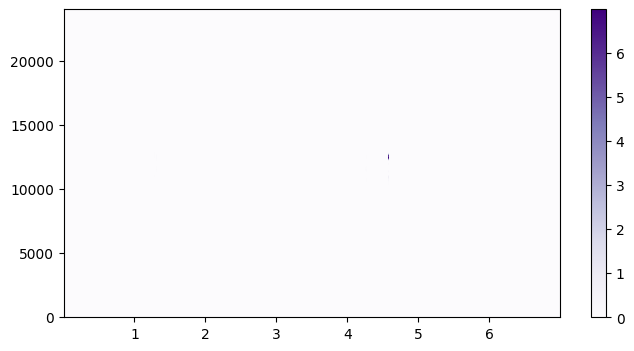

In [4]:
#audio file path
path = "cut_filtered/03-10-3022_30_38_28.0_35.0_med|high_10800_19200.wav"

# open the file

maxFreqForInterval = 13687.5

#Get spectrogram data
calculateSpecT = time.time()
t,freq,spec = specInfo(path)
print(t)
print(freq)

# not used
frequencyLimit = ((np.abs(freq - maxFreqForInterval)).argmin()+1)


print("Spectrogram calculation time:", time.time()- calculateSpecT, "seconds")#outputs spectrogram calculation time
#Plot spectrogram dataspecInfo
plotModSpecSimple(t,freq,spec)

In [5]:
dataDescription = pd.read_csv("data.csv") 
dataDescription.head()
# remove the first row and save it in a new variable
firstRow = dataDescription.iloc[0]
dataDescription.drop(0, inplace=True)

In [6]:
MarkIndex = 0
# file = 
minimumFrequency = 19200
maximumFreqeuency = 23000
startTime = 0
endTime = 7
durationTime = 3220
# split the file into 7 seconds
# dictionary with 8 keys
dic = {}
# for i in range(8):
#     # get minimum frequency, maximum frequency, start time, end time
#     dic[i] = getMarcaFromSpectrogram(t, freq, spec, minimumFrequency, maximumFreqeuency, startTime, endTime, 2760) 
#     startTime += 7
#     endTime += 7
#     minimumFrequency += maximumFreqeuency



# print(file)
print(minimumFrequency)
print(maximumFreqeuency)
print(startTime)
print(endTime)

#Set a default value for Duration of mark 
# revisar
#milliseconds???????????????????????   


19200
23000
0
7


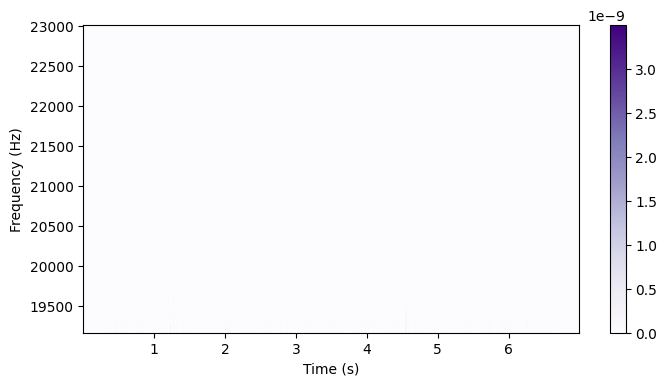

In [7]:
#Get spectrogram information of mark
tSelect, freqSelect, specSelect, minFreq, maxFreq = getMarcaFromSpectrogram(t,freq,spec, minimumFrequency,maximumFreqeuency, startTime,endTime, durationTime)



# print(freqSelect)
# print(specSelect)

#Plot the mark


plotModSpecSimple(tSelect, freqSelect, specSelect, ylab = "Frequency (Hz)", xlab = "Time (s)")

In [8]:
#Define clusters and kmeans cluster instace
clusters = 6
kCluster = KMeans(clusters)

#First we must flatten the data to cluster it (1 dimensional vector)
specSelectFlatten = specSelect.flatten().reshape(-1,1)

Y axis in this plot is a density proportion of the count for each bin in magnitude values


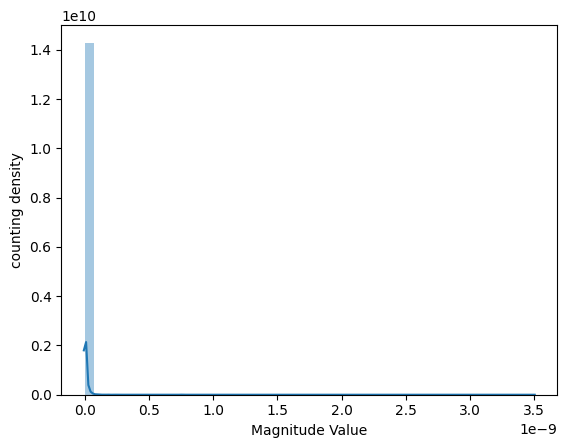

In [9]:
#Plot a histogram of magnitude values
ax = sns.distplot(specSelectFlatten, hist = True, norm_hist=False, axlabel= "Magnitude Value")
ax.set_ylabel("counting density")
print("Y axis in this plot is a density proportion of the count for each bin in magnitude values")

In [10]:

#Cluster the magnitude values
#The returning vector will contain the cluster group associated to each entry 
specSelectFlattenCluster = kCluster.fit_predict(specSelectFlatten)

In [11]:
#Make sure we order labels based on cluster's magnitude
specSelectFlattenCluster, clusterMax = orderClusters(specSelectFlattenCluster, specSelectFlatten, clusters,  True)

Text(0.5, 0, 'Magnitude values')

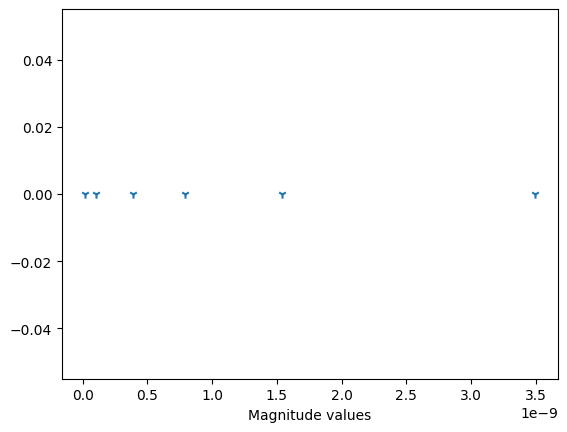

In [12]:
#Representation of clusters, between each marker is a cluster group
plt.scatter(np.concatenate(clusterMax), [[0]*clusters], marker = "1")
plt.xlabel("Magnitude values")


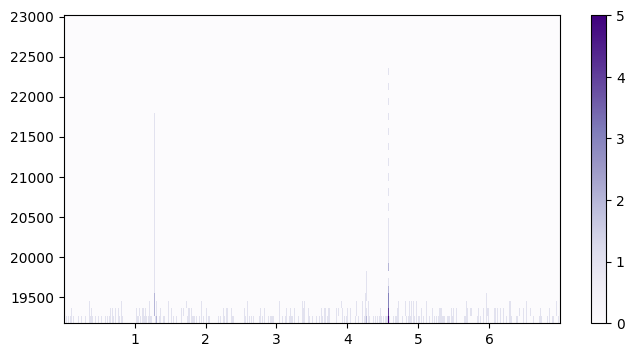

In [13]:
#Display how mark looks like after clutering magnitude values
plotModSpecSimple(tSelect,freqSelect , specSelectFlattenCluster.reshape(specSelect.shape))

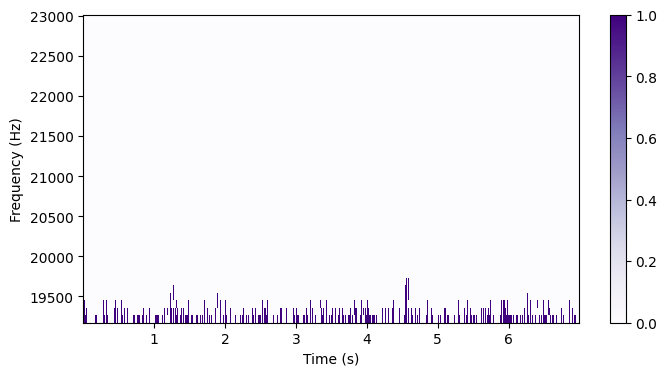

In [14]:
#Prepare data
#Set all values other than 0 to 1 
correctingIdx = np.where(specSelectFlattenCluster != 0)[0]
copySelectFlattenCluster = specSelectFlattenCluster
specSelectFlattenCluster = np.zeros(specSelectFlatten.shape)

#Set all values not equal to 0 to 1. 
specSelectFlattenCluster[correctingIdx] = 1
plotModSpecSimple(tSelect,freqSelect , specSelectFlattenCluster.reshape(specSelect.shape),  ylab = "Frequency (Hz)", xlab = "Time (s)")

In [15]:
#Get coordinates of relevant points (Coordinates of those values containing 1)
yIndeces, xIndeces = np.where(specSelectFlattenCluster.reshape(specSelect.shape) ==  1)
coordinatesArray = np.array([yIndeces, xIndeces]).T


In [16]:
#Define DBScan instace
DBScan = DBSCAN(eps = 2, min_samples = 8)

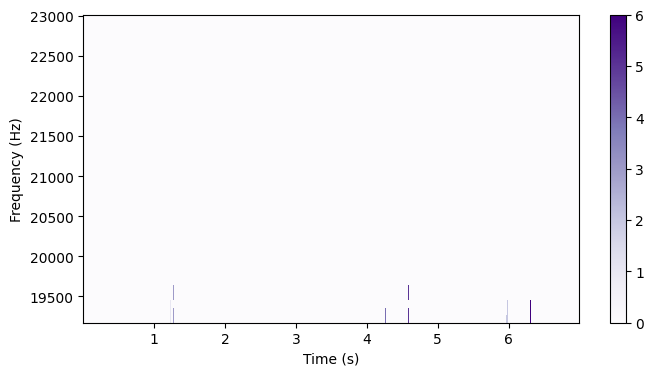

In [17]:
detectedGroups = DBScan.fit_predict(coordinatesArray)

#Get min and max groups (if min = -1, some points where not clustered) max will contain the number of cluster groups found
minIndex = np.min(detectedGroups)


#In order to have a range from 0 to 1, add abs value of minIndex ( if min index = 0 , it will remain the same
#if minIndex == -1, it will relocate range from 0 to maxIndex+1)
copySelectFlattenCluster[correctingIdx] = detectedGroups + abs(minIndex)
detectedGroups += abs(minIndex)
plotModSpecSimple(tSelect,freqSelect,copySelectFlattenCluster.reshape(specSelect.shape), xlab = "Time (s)", ylab = "Frequency (Hz)")

displayGroups = np.zeros(specSelect.shape)

for ctr, i in enumerate(coordinatesArray):
    displayGroups[int(i[0])][ int(i[1])] = detectedGroups[ctr]
maxIndex = np.max(detectedGroups)

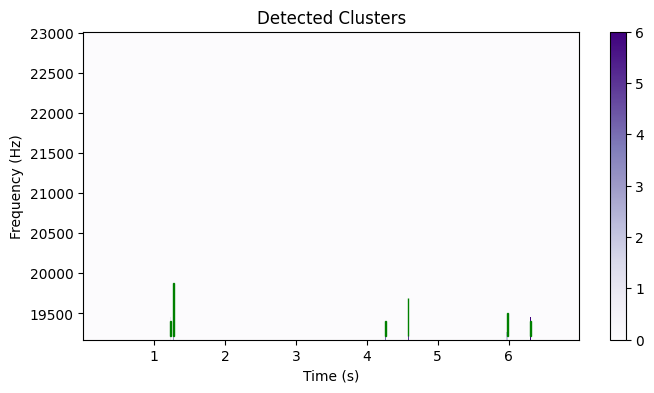

In [18]:
rect = []
for speechValue in range(1, maxIndex+1):
    if len(np.where(detectedGroups== speechValue)[0]) != 0 :
        
        #Get min and max time and frequency values of the identified cluster groups
        minf = np.min(np.where(displayGroups == speechValue)[0])
        maxf = np.max(np.where(displayGroups == speechValue)[0])
        startT = np.min(np.where(displayGroups == speechValue)[1])
        endT = np.max(np.where(displayGroups == speechValue)[1])

        #Create bounding box and add to boxes to be displayed
        rect.append(patches.Rectangle((tSelect[startT],freqSelect[minf]),tSelect[endT]-tSelect[startT],freqSelect[maxf]-freqSelect[minf],linewidth=1,edgecolor='g',facecolor='none'))

#Display marc with bounding boxes around the cluster groups found
plotModSpecSimple(tSelect,freqSelect,displayGroups, xlab = "Time (s)", ylab = "Frequency (Hz)", title = "Detected Clusters", patch = rect)


In [19]:
#Define training model parameters
#These two parameters are used to define how many time steps and frequencies will the training model have
timeInterval = 469
frequencyInterval = 86
print(maxIndex)

for speechValue in range(1, maxIndex+1):
    speechIndexes = np.where(detectedGroups == speechValue)[0]

    minVal = np.min(coordinatesArray[speechIndexes], axis = 0)[1]

    # print('hello')
    trainMatrix = np.zeros((frequencyInterval ,timeInterval))

    for ctr, i in enumerate(coordinatesArray[speechIndexes]):
        if i[1] - minVal < timeInterval:
            try:
                trainMatrix[int(i[0])+minFreq][ int(i[1])-minVal] =1
            except:
                pass
    # X = np.linspace(0, t[timeInterval], timeInterval+1)
    # Y = np.linspace(0, freq[frequencyInterval], frequencyInterval+1)
    # print(t[0:timeInterval].shape)
    # print(t.shape)
    # print(t)
    # print(trainMatrix.shape)

    # plotModSpecSimple(X,Y,trainMatrix, xlab = "Time (s)", ylab = "Frequency (Hz)")
    # plotModSpecSitmple(t[0:timeInterval], freq[0:frequencyInterval],trainMatrix, xlab = "Time (s)", ylab = "Frequency (Hz)")    

6


In [20]:
trainMatrix.shape

(86, 469)

In [21]:
# load the model from disk
from keras.models import load_model

model = load_model('kaggle_model_mar16.h5')

2023-05-04 15:20:34.489283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-04 15:20:34.489312: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-04 15:20:34.489330: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Ursa): /proc/driver/nvidia/version does not exist
2023-05-04 15:20:34.489562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# predict trainMatrix
print(trainMatrix.shape)
prediction = model.predict(trainMatrix.reshape(1,86,469))
# prediction = model.predict(trainMatrix)

# # print prediction
# print(prediction)


# print the label the model predicted
# print(np.argmax(prediction))

# test with noise, and cut the arbimon ones into 7 splts as well. See if it still works correctly
# see if it can detect the noise, and if it can detect the arbimon ones correctly
# get the whole vector, collect that data and see if theres two
#  configure it as a csv and have probability columns


# check if I can run jupyter, on terminal without screen.



(86, 469)
1/1 [==============================] - 0s 118ms/step


In [23]:
# create csv
name = "results_diff.csv"
columns = ["filename", "label_0_prob", "label_1_prob", "label_2_prob", "label_3_prob", "label_4_prob", "label_5_prob", "label_6_prob", "predicted_label"]
df = pd.DataFrame(columns=columns)

# write the data to csv

item = {
    "filename": path,
    "label_1_prob": prediction[0][0],
    "label_2_prob": prediction[0][1],
    "label_3_prob": prediction[0][2],
    "label_4_prob": prediction[0][3],
    "label_5_prob": prediction[0][4],
    "label_6_prob": prediction[0][5],
    "label_7_prob": prediction[0][6],
    "predicted_label": np.argmax(prediction)
}

# df = pd.concat([df, pd.DataFrame([item])], ignore_index=True)
# df.to_csv(name, index=False)


Funcion para crear el dataset

In [24]:
def transformData(datadir, timeIndex, df):
    # loop thru directory
    i = 0
    for filename in os.listdir(datadir):
        path = os.path.join(datadir, filename)
        path = str(path)
        t,freq,spec = specInfo(path)
        minimumFrequency = filename.split('_')[6]
        maximumFreqeuency = filename.split('_')[7].split('.')[0]
        startTime = 0
        endTime = 7

        tSelect, freqSelect, specSelect, minFreq, maxFreq= getMarcaFromSpectrogram(t,freq,spec, minimumFrequency,maximumFreqeuency, startTime,endTime, 3220)
#                 return 0 

        #Cluster noise
        specSelectFlatten = specSelect.flatten().reshape(-1,1)

        specSelectFlattenCluster = kCluster.fit_predict(specSelectFlatten)
        specSelectFlattenCluster, clusterMax = orderClusters(specSelectFlattenCluster, specSelectFlatten, 6,  True)


        correctingIdx = np.where(specSelectFlattenCluster != 0)[0]
        copySelectFlattenCluster = specSelectFlattenCluster
        specSelectFlattenCluster = np.zeros(specSelectFlatten.shape)

        #Set all values not equal to 0 to 1. 
        specSelectFlattenCluster[correctingIdx] = 1
        #plotModSpecSimple(tSelect,freqSelect , specSelectFlattenCluster.reshape(specSelect.shape),  ylab = "Frequency (Hz)", xlab = "Time (s)")

        #Get coordinates of relevant points (Coordinates of those values containing 1)
        yIndeces, xIndeces = np.where(specSelectFlattenCluster.reshape(specSelect.shape) ==  1)
        coordinatesArray = np.array([yIndeces, xIndeces]).T

        detectedGroups = DBScan.fit_predict(coordinatesArray)

        #Get min and max groups (if min = -1, some points where not clustered) max will contain the number of cluster groups found
        minIndex = np.min(detectedGroups)
        detectedGroups += abs(minIndex)
        maxIndex = np.max(detectedGroups)

        trainMatrix = np.zeros((frequencyInterval ,timeIndex), dtype = "int8")

        for speechValue in range(1, maxIndex+1):
            speechIndexes = np.where(detectedGroups == speechValue)[0]

            minVal = np.min(coordinatesArray[speechIndexes], axis = 0)[1]

            trainMatrix[:,:] = 0

            for ctr, i in enumerate(coordinatesArray[speechIndexes]):
                if i[1] - minVal < timeInterval:
                    try:
                        trainMatrix[int(i[0])+minFreq][ int(i[1])-minVal] =1
                    except:
                        pass
        # predict trainMatrix
        # print(trainMatrix.shape)
        prediction = model.predict(trainMatrix.reshape(1,86,469))
        item = {
            "filename": os.path.join(datadir, filename),
            "label_0_prob": prediction[0][0],
            "label_1_prob": prediction[0][1],
            "label_2_prob": prediction[0][2],
            "label_3_prob": prediction[0][3],
            "label_4_prob": prediction[0][4],
            "label_5_prob": prediction[0][5],
            "label_6_prob": prediction[0][6],
            "predicted_label": np.argmax(prediction)
        }
        df = pd.concat([df, pd.DataFrame([item])], ignore_index=True)

    df.to_csv(name, index=False)
    # grab the data from the csv
    df = pd.read_csv(name)
    # get all the numbers in the mode of the predicted label
    mode = df["predicted_label"].mode()
    # get all the unique values in the predicted label
    unique = df["predicted_label"].unique()

    # print the labels that are the most common
    print('the most common labels are: ', mode)
    # print the unique labels
    print('the unique labels are: ', unique)


In [25]:
audio_dir = 'cut_filtered'
transformData(audio_dir, timeIndex= 469, df = df)

1/1 [==============================] - 0s 20ms/step
the most common labels are:  0    2
Name: predicted_label, dtype: int64
the unique labels are:  [2 4 0]


Set up random que no se que hace

Get amount of labels

Get amount of samples